In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import shutil

!pip install tensorboardcolab
import tensorboardcolab

import sys

Using TensorFlow backend.


In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# DataProvider

In [0]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

In [0]:
from tensorflow.keras.datasets.cifar10 import load_data
(train_x, train_y), (test_x, test_y) = load_data()

# rank2 -> rank1 
test_y = test_y.reshape(-1)
train_y = train_y.reshape(-1)

## normalization 
train_x, test_x = [x /255. for x in [train_x, test_x]]

In [0]:
import random

class DataProvider(object):
    def __init__(self, images, labels):
        self.n_sample = len(labels)
        self.queue = list(range(self.n_sample))
        random.shuffle(self.queue)

        self.images = images
        self.labels = labels
        self.epoch_count = 0

    def next_batch(self, batch_size):
        if len(self.queue) < batch_size:
            self.queue = list(range(self.n_sample))
            self.epoch_count += 1
        target_indices = self.queue[:batch_size]
        del self.queue[:batch_size]
        return self.images[target_indices], self.labels[target_indices]

In [0]:
def image_augmentation(image, is_training, crop_h, crop_w):

    def _aug_with_train(input_x, crop_height, crop_width):
        img_h, img_w, ch = list(map(int, input_x.get_shape()[:]))

        pad_w = int(img_h * 0.2)
        pad_h = int(img_w * 0.2)

        input_x = tf.image.resize_image_with_crop_or_pad(input_x, img_h+pad_h, img_w+pad_w)
        input_x = tf.random_crop(input_x, [crop_height, crop_width, ch])
        input_x = tf.image.random_flip_left_right(input_x)
        input_x = tf.image.random_flip_up_down(input_x)

        input_x = tf.image.random_contrast(input_x, lower=0.2,upper=2.0)
        input_x = tf.image.random_brightness(input_x, max_delta=63. / 255.)
        input_x = tf.image.random_saturation(input_x, lower=0.5, upper=1.8)
        input_x = tf.image.per_image_standardization(input_x)
        return input_x

    def _aug_with_test(input_x, crop_height, crop_width):

        input_x = tf.image.resize_image_with_crop_or_pad(input_x, crop_height, crop_width)
        input_x = tf.image.per_image_standardization(input_x)
        return input_x

    image = tf.cond(is_training,
                    lambda: _aug_with_train(image, crop_h, crop_w),
                    lambda: _aug_with_test(image, crop_h, crop_w))
    return image

def images_augmentation(images, phase_train):
    with tf.name_scope('augmentation'):
        crop_h, crop_w = list(map(int, images.get_shape()[1:3]))
        images = tf.map_fn(lambda image : image_augmentation(image, phase_train, crop_h, crop_w),
                  images)
        return images

In [0]:
def batch_norm_(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        if len(x.get_shape()) == 4:
            batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        elif len(x.get_shape()) == 2:
            batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
            
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean),
                                     ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [0]:
def residual_block(input_data, filters, strides, is_train, block_name) :
    #print('input_shape : ', input_data.shape)
    
    #he_init = tf.initializers.he_normal()

    with tf.variable_scope(block_name):
        # Layer1
        with tf.variable_scope('layer1'):
            layer = tf.layers.Conv2D(filters=filters, kernel_size = 3, use_bias=False,
                                   strides=strides, padding = 'SAME', activation=None)\
                                    (input_data)
            layer = batch_norm_(layer, filters, is_train)
            layer = tf.nn.relu(layer)
        
        # Layer2    
        with tf.variable_scope('layer2'):        
            layer = tf.layers.Conv2D(filters = filters, kernel_size = 3, use_bias=False,
                                   strides = strides, padding = 'SAME', activation=None)\
                                    (layer)
            layer = batch_norm_(layer, filters, is_train)
            layer = tf.nn.relu(layer)
        
        # Projection layer
        if input_data.shape[-1] != filters :
            input_data = tf.layers.Conv2D(filters = filters, kernel_size = 1, 
                                           strides = 1,
                                           padding='SAME',
                                           activation=tf.nn.relu
                                           )(input_data)

        return layer + input_data
    

In [9]:
graph1 = tf.Graph()
with graph1.as_default() :
    xs = tf.placeholder(dtype = tf.float32, shape=(None, 32, 32, 3))
    ys = tf.placeholder(dtype = tf.int64, shape=(None,))
    is_train = tf.placeholder_with_default(True, (), name='is_train')
    
    xs_aug = images_augmentation(xs, is_train)
    #he_init = tf.initializers.he_normal()
    
    layer = tf.layers.Conv2D(filters = 16, kernel_size = 3, strides=1, padding = 'SAME')(xs_aug)

    layer = residual_block(layer, 16, 1, is_train, 'resnet_1_1')
    layer = tf.layers.MaxPooling2D(2, 2)(layer)
    layer = residual_block(layer, 32, 1, is_train, 'resnet_2_1')
    layer = tf.layers.MaxPooling2D(2, 2)(layer)
    layer = residual_block(layer, 64, 1, is_train, 'resnet_3_1')
    layer = tf.layers.MaxPooling2D(2, 2)(layer)
    layer = residual_block(layer, 128, 1, is_train, 'resnet_4_1')
    layer = tf.layers.AveragePooling2D( (layer.get_shape()[1],layer.get_shape()[2]) , 1)(layer)
    
    layer = tf.layers.Flatten()(layer)
    logits = tf.layers.Dense(units = 10, activation = None)(layer)

W0706 08:01:18.530786 140373342508928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/image_ops_impl.py:1514: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0706 08:01:18.573825 140373342508928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
show_graph(graph1)

In [0]:
 with graph1.as_default() :
    with tf.variable_scope('loss') :
        weight_decay = 5e-4
        sce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = ys,
                                                      logits = logits)
        weights = graph1.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='^.*/kernel.*$')
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) 
                           for weight in weights])
        loss = tf.reduce_mean(sce, name='loss') + l2_loss * weight_decay
    loss = tf.identity(loss, name='loss')  

In [0]:
with graph1.as_default() :
    with tf.variable_scope('metric_acc') :
        pred_val = tf.argmax(logits,axis=1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred_val, ys), tf.float32))

In [0]:
with graph1.as_default() :
    momentum = 0.9
    lr = tf.placeholder(tf.float32, (), name='learning_rate')    
    global_step = tf.train.get_or_create_global_step()
    with tf.variable_scope("optimizer"):
        train_op = (tf.train.MomentumOptimizer(lr, momentum = momentum)\
                .minimize(loss, global_step=global_step))

In [14]:
with graph1.as_default() :
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    provider = DataProvider(train_x, train_y)
    loss_list = []
    acc_list = []
    loss_val_list = []
    acc_val_list = []
    j = 0
    
    for i in range(10000) :
        data, label = provider.next_batch(100)
        
        sess.run(train_op, {xs : data, ys : label, is_train : True, lr : 0.01})
        
        if i % 100 == 0 :
            
            loss_val, acc_val = sess.run([loss, acc],
                                                  feed_dict = { xs : test_x,
                                                               ys : test_y,
                                                              is_train : False})
            
            data, label = provider.next_batch(10000)
            loss_, acc_ = sess.run([loss, acc],
                                              feed_dict = {xs : data,
                                                          ys : label,
                                                          is_train : False})
            loss_list.append(loss_)
            acc_list.append(acc_)
            loss_val_list.append(loss_val)
            acc_val_list.append(acc_val)
            
            print('step : {}, train_loss : {:5.3}, train_acc : {:5.3}, vali_loss : {:5.3}, vali_acc : {:5.3}'.\
                  format(i,loss_, acc_, loss_val, acc_val))
            

step : 0, train_loss :  48.2, train_acc : 0.0993, vali_loss :  48.3, vali_acc :   0.1
step : 100, train_loss :  1.88, train_acc : 0.354, vali_loss :  1.87, vali_acc : 0.362
step : 200, train_loss :  1.86, train_acc : 0.384, vali_loss :  1.87, vali_acc : 0.384
step : 300, train_loss :  1.69, train_acc : 0.452, vali_loss :  1.72, vali_acc :  0.44
step : 400, train_loss :  1.51, train_acc : 0.509, vali_loss :  1.51, vali_acc : 0.509
step : 500, train_loss :  1.52, train_acc : 0.509, vali_loss :   1.5, vali_acc : 0.517
step : 600, train_loss :   1.4, train_acc : 0.551, vali_loss :  1.39, vali_acc : 0.553
step : 700, train_loss :   1.4, train_acc : 0.541, vali_loss :  1.41, vali_acc : 0.545
step : 800, train_loss :  1.32, train_acc : 0.584, vali_loss :  1.35, vali_acc : 0.574
step : 900, train_loss :  1.31, train_acc :  0.58, vali_loss :  1.34, vali_acc : 0.571
step : 1000, train_loss :  1.36, train_acc : 0.572, vali_loss :  1.36, vali_acc :  0.57
step : 1100, train_loss :  1.25, train_acc 

In [21]:
with graph1.as_default() :
   
    for i in range(10000, 20000) :
        data, label = provider.next_batch(100)
        
        sess.run(train_op, {xs : data, ys : label, is_train : True, lr : 0.001})
        
        if i % 100 == 0 :
            
            loss_val, acc_val = sess.run([loss, acc],
                                                  feed_dict = { xs : test_x,
                                                               ys : test_y,
                                                              is_train : False})
            
            data, label = provider.next_batch(10000)
            loss_, acc_ = sess.run([loss, acc],
                                              feed_dict = {xs : data,
                                                          ys : label,
                                                          is_train : False})
            loss_list.append(loss_)
            acc_list.append(acc_)
            loss_val_list.append(loss_val)
            acc_val_list.append(acc_val)
            
            print('step : {}, train_loss : {:5.3}, train_acc : {:5.3}, vali_loss : {:5.3}, vali_acc : {:5.3}'.\
                  format(i,loss_, acc_, loss_val, acc_val))

step : 10000, train_loss : 0.605, train_acc : 0.838, vali_loss : 0.684, vali_acc : 0.807
step : 10100, train_loss : 0.607, train_acc : 0.834, vali_loss : 0.677, vali_acc : 0.808
step : 10200, train_loss : 0.584, train_acc : 0.841, vali_loss : 0.684, vali_acc : 0.806
step : 10300, train_loss :  0.59, train_acc : 0.837, vali_loss : 0.676, vali_acc :  0.81
step : 10400, train_loss : 0.576, train_acc : 0.844, vali_loss : 0.678, vali_acc : 0.809
step : 10500, train_loss : 0.593, train_acc : 0.839, vali_loss : 0.687, vali_acc : 0.807
step : 10600, train_loss :  0.58, train_acc : 0.843, vali_loss : 0.675, vali_acc :  0.81
step : 10700, train_loss : 0.607, train_acc : 0.835, vali_loss : 0.684, vali_acc : 0.808
step : 10800, train_loss : 0.611, train_acc : 0.834, vali_loss : 0.681, vali_acc : 0.809
step : 10900, train_loss : 0.573, train_acc : 0.847, vali_loss : 0.672, vali_acc : 0.813
step : 11000, train_loss : 0.586, train_acc : 0.841, vali_loss : 0.681, vali_acc : 0.811
step : 11100, train_l

KeyboardInterrupt: ignored

In [22]:
with graph1.as_default() :
   
    for i in range(11300, 20000) :
        data, label = provider.next_batch(100)
        
        sess.run(train_op, {xs : data, ys : label, is_train : True, lr : 0.0001})
        
        if i % 100 == 0 :
            
            loss_val, acc_val = sess.run([loss, acc],
                                                  feed_dict = { xs : test_x,
                                                               ys : test_y,
                                                              is_train : False})
            
            data, label = provider.next_batch(10000)
            loss_, acc_ = sess.run([loss, acc],
                                              feed_dict = {xs : data,
                                                          ys : label,
                                                          is_train : False})
            loss_list.append(loss_)
            acc_list.append(acc_)
            loss_val_list.append(loss_val)
            acc_val_list.append(acc_val)
            
            print('step : {}, train_loss : {:5.3}, train_acc : {:5.3}, vali_loss : {:5.3}, vali_acc : {:5.3}'.\
                  format(i,loss_, acc_, loss_val, acc_val))

step : 11300, train_loss : 0.564, train_acc : 0.849, vali_loss : 0.668, vali_acc : 0.811
step : 11400, train_loss : 0.583, train_acc : 0.841, vali_loss : 0.683, vali_acc : 0.806
step : 11500, train_loss :  0.58, train_acc : 0.846, vali_loss : 0.674, vali_acc : 0.811
step : 11600, train_loss : 0.604, train_acc : 0.837, vali_loss : 0.682, vali_acc : 0.808
step : 11700, train_loss : 0.602, train_acc : 0.838, vali_loss : 0.673, vali_acc : 0.811
step : 11800, train_loss : 0.564, train_acc : 0.848, vali_loss :  0.67, vali_acc : 0.814
step : 11900, train_loss : 0.578, train_acc : 0.843, vali_loss : 0.678, vali_acc : 0.809
step : 12000, train_loss : 0.576, train_acc : 0.847, vali_loss : 0.669, vali_acc : 0.813
step : 12100, train_loss : 0.601, train_acc : 0.839, vali_loss : 0.679, vali_acc : 0.808
step : 12200, train_loss : 0.599, train_acc : 0.838, vali_loss : 0.671, vali_acc : 0.812
step : 12300, train_loss :  0.56, train_acc : 0.851, vali_loss : 0.666, vali_acc : 0.815
step : 12400, train_l

KeyboardInterrupt: ignored

In [23]:
with graph1.as_default() :
   
    for i in range(16000, 20000) :
        data, label = provider.next_batch(100)
        
        sess.run(train_op, {xs : data, ys : label, is_train : True, lr : 0.00001})
        
        if i % 100 == 0 :
            
            loss_val, acc_val = sess.run([loss, acc],
                                                  feed_dict = { xs : test_x,
                                                               ys : test_y,
                                                              is_train : False})
            
            data, label = provider.next_batch(10000)
            loss_, acc_ = sess.run([loss, acc],
                                              feed_dict = {xs : data,
                                                          ys : label,
                                                          is_train : False})
            loss_list.append(loss_)
            acc_list.append(acc_)
            loss_val_list.append(loss_val)
            acc_val_list.append(acc_val)
            
            print('step : {}, train_loss : {:5.3}, train_acc : {:5.3}, vali_loss : {:5.3}, vali_acc : {:5.3}'.\
                  format(i,loss_, acc_, loss_val, acc_val))

step : 16000, train_loss : 0.559, train_acc : 0.853, vali_loss : 0.664, vali_acc : 0.814
step : 16100, train_loss : 0.575, train_acc : 0.845, vali_loss : 0.675, vali_acc :  0.81
step : 16200, train_loss : 0.556, train_acc : 0.852, vali_loss : 0.661, vali_acc : 0.813
step : 16300, train_loss : 0.573, train_acc : 0.845, vali_loss : 0.673, vali_acc : 0.811
step : 16400, train_loss : 0.571, train_acc : 0.848, vali_loss : 0.667, vali_acc : 0.814
step : 16500, train_loss : 0.588, train_acc : 0.842, vali_loss : 0.669, vali_acc : 0.813
step : 16600, train_loss : 0.592, train_acc : 0.838, vali_loss : 0.665, vali_acc : 0.813
step : 16700, train_loss : 0.559, train_acc : 0.851, vali_loss : 0.665, vali_acc : 0.813
step : 16800, train_loss :  0.57, train_acc : 0.847, vali_loss :  0.67, vali_acc : 0.811
step : 16900, train_loss : 0.569, train_acc : 0.849, vali_loss : 0.663, vali_acc : 0.813
step : 17000, train_loss : 0.591, train_acc : 0.841, vali_loss : 0.672, vali_acc : 0.812
step : 17100, train_l

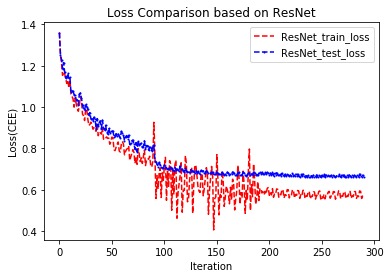

In [54]:
plt.title('Loss Comparison based on ResNet')
plt.xlabel('Iteration')
plt.ylabel('Loss(CEE)')
plt.plot(loss_list[10:], 'r--', label = 'ResNet_train_loss')
plt.plot(loss_val_list[10:], 'b--o', markersize=1, markeredgecolor='b', label = 'ResNet_test_loss')
plt.legend()
plt.show()

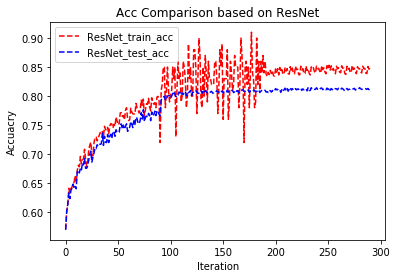

In [76]:
plt.title('Acc Comparison based on ResNet')
plt.xlabel('Iteration')
plt.ylabel('Accuacry')
plt.plot(acc_list[10:], color='r', linestyle='--',
         label = 'ResNet_train_acc')
plt.plot(acc_val_list[10:],color='b', linestyle='--', markersize=1, markeredgecolor='b', label = 'ResNet_test_acc')
plt.legend()